# Data Analysis using XGBoost

## Importing Required Libraries

In [1]:
%matplotlib inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lib import XGBHelper as xgbh

## Loading Data

The data files were preprocessed on PySpark (10 nodes) cluster. The code for the same can be found [here](Data_Processing_Whales.ipynb). The preprocessed is a numpy array with `4175` rows (for the 10mb file) with following columns (zero-indexed):
* Col 0-9: projections on first 10 eigen vectors
* Col 10: rmse
* Col 11: peak2peak
* Col 12: label (`0 if row.species==u'Gervais' else 1`)

In [3]:
#Use Data/processed_data_150mb.np for a slightly bigger file
data  = np.load("Data/processed_data_15mb.np")
X = data[:, :-1]
y = np.array(data[:, -1], dtype=int)

## Train - Test - Validation

The data is shuffled and divided as follow:
* Training: 70%
* Validation: 15%
* Testing: 15%

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model Training and Feature Visualization

## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3 _(maximum depth of each decision trees)_
* Step size shrinkage used in update to prevents overfitting = 0.3 _(how to weigh trees in subsequent iterations)_
* Evaluation Criterion= `Maximize Loglikelihood` _(maximizing cross entropy)_
* Maximum Number of Iterations = 1000 _(total number trees for boosting)_
* Early Stop if score on Validation does not improve for 5 iterations

In [5]:
param = {'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic'}

# total number of cores to use
param['nthread'] = 7 
param['eval_metric'] = 'logloss'

plst = param.items()
evallist = [(dtrain, 'train'), (dtest, 'eval')]

## Training the model

Note: Running XGBoost for 1000 iterations takes about 70-80 minutes to train. Use **verbose_eval=True** to track number of iterations complete.

In [10]:
# bst is model with 100 iterations
num_round = 100
# Use early_stopping_rounds=5 to enable early stopping
bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False)

# bst1000 is model with 1000 iterations
num_round = 1000
# Use early_stopping_rounds=5 to enable early stopping
bst1000 = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False)

## Visualize the Feature Importance

In [11]:
features_map = {'f0' : 'Eigen Projection 1', 'f1' : 'Eigen Projection 2',
                'f2' : 'Eigen Projection 3', 'f3' : 'Eigen Projection 4',
                'f4' : 'Eigen Projection 5', 'f5' : 'Eigen Projection 6',
                'f6' : 'Eigen Projection 7', 'f7' : 'Eigen Projection 8',
                'f8' : 'Eigen Projection 9', 'f9' : 'Eigen Projection 10',
                'f10' : 'RMSE', 'f11' : 'Peak2Peak'}

100 Iterations


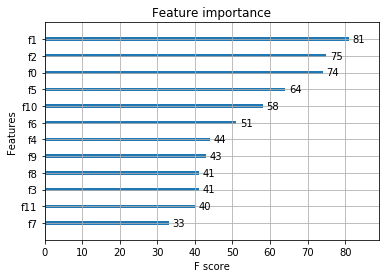

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [12]:
print("100 Iterations")
xgbh.visualize_features(bst, features_map)

1000 Iterations


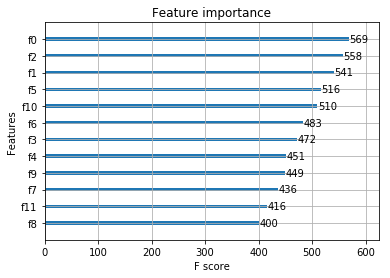

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [13]:
print("1000 Iterations")
xgbh.visualize_features(bst1000, features_map)

**Observation**: Clearly, Eigen Projection 2, Eigen Projection 3, Eigen Projection 1, RMSE and Peak2Peak are the most important features.

# Margin Plots on Test Data

In [14]:
y_pred_100 = bst.predict(dtest, ntree_limit=bst.best_ntree_limit, output_margin=True)
y_pred_1000 = bst1000.predict(dtest, ntree_limit=bst1000.best_ntree_limit, output_margin=True)
y_test = dtest.get_label()

In [22]:
# #Uncomment this part if you want to load directly from the pickle file instead of running XGBoost for 1000 iterations on the entire data.
# #Processed pickle file (xgboost_output_full_data.pk) has been provided. 
# import pickle

# #Processed output after running them on a model
# p = pickle.load(open('Data/xgboost_output_full_data.pk', 'rb'))

# y_test = np.array(p['y_test'], dtype = int)
# y_pred_100 = p['y_pred_100']
# y_pred_1000 = p['y_pred_1000']

In [23]:
## For 100 iterations
thresholds_100 = sorted(np.unique(np.round(y_pred_100, 2)))
error_cuv_100, error_ger_100 = xgbh.get_error_values(y_pred_100, y_test, thresholds_100)

## For 1000 interations
thresholds_1000 = sorted(np.unique(np.round(y_pred_1000, 2)))
error_cuv_1000, error_ger_1000 = xgbh.get_error_values(y_pred_1000, y_test, thresholds_1000)

## Error plot XGBoost

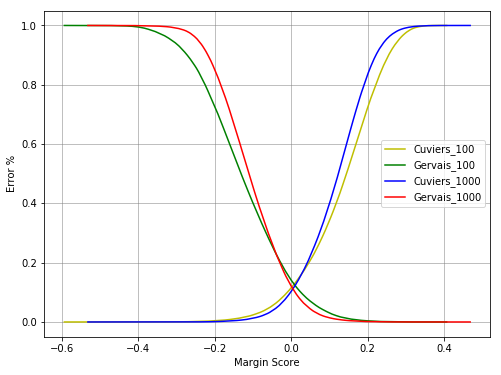

In [24]:
plt.figure(figsize=(8, 6))
legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

## Highlighting region of importance

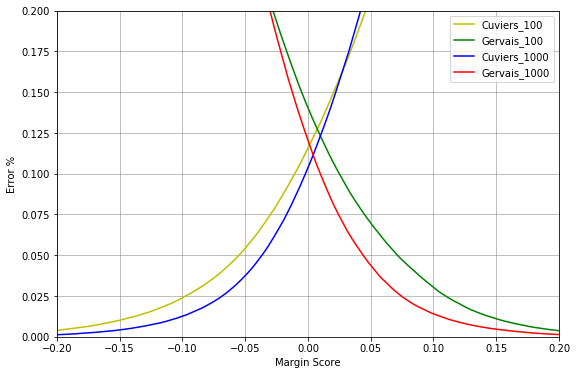

In [25]:
plt.figure(figsize=(9, 6))

legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])

legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.xlim([-0.2, 0.2])
plt.ylim([0, 0.2])
plt.show()

## ROC Curve

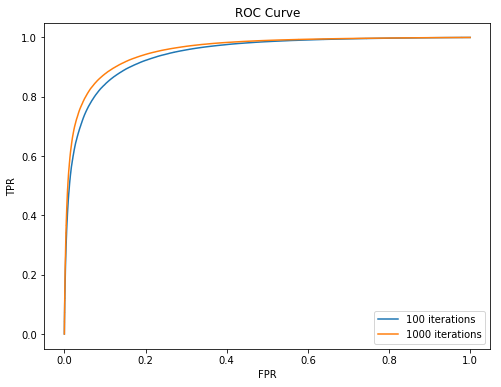

In [26]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_100)
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1000)
plt.plot(fpr, tpr)
plt.legend(['100 iterations','1000 iterations'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.show()

# ROC Analysis

Thresholds (lower, upper): -0.08651597 0.12308685
Accuracy: 0.976855,
Cuvier Accuracy: 0.985415,
Gervais Accuracy: 0.968822,
Abstain: 0.440469


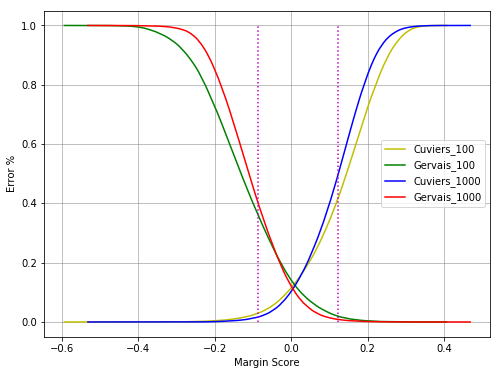

In [27]:
thr_lower_index = np.min(np.where((tpr > 0.95) & (fpr > 0.4)))
thr_upper_index = np.max(np.where((tpr < 0.5) & (fpr  < 0.05)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
#print("Thresholds (lower, upper):", thr_lower, thr_upper)

acc, cuvier_acc, gervais_acc, abstain = xgbh.statistics(y_pred_1000, y_test, thr_lower, thr_upper)

thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)

print("Accuracy: %f,\nCuvier Accuracy: %f,\nGervais Accuracy: %f,\nAbstain: %f" % (acc, cuvier_acc, gervais_acc, abstain))

plt.figure(figsize=(8, 6))
legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

Accuracy: 0.953639,
Cuvier Accuracy: 0.979913,
Gervais Accuracy: 0.931645,
Abstain: 0.282628
Thresholds (lower, upper): -0.036593918 0.10004389


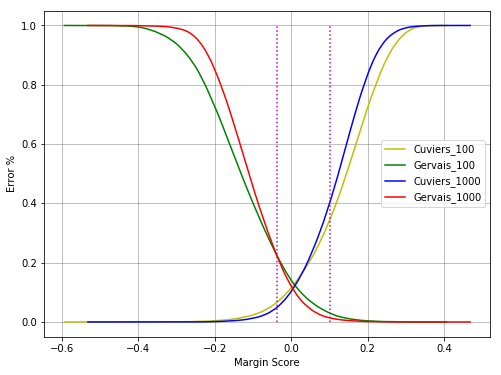

In [28]:
thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
#print("Thresholds (lower, upper):", thr_lower, thr_upper)
acc,cuvier_acc, gervais_acc, abstain = xgbh.statistics(y_pred_1000, y_test, thr_lower, thr_upper)
print("Accuracy: %f,\nCuvier Accuracy: %f,\nGervais Accuracy: %f,\nAbstain: %f" % (acc, cuvier_acc, gervais_acc, abstain))

thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)

plt.figure(figsize=(8, 6))
legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

Accuracy: 0.926162,
Cuvier Accuracy: 0.990632,
Gervais Accuracy: 0.902342,
Abstain: 0.401091
Thresholds (lower, upper): -0.013772231 0.16625665


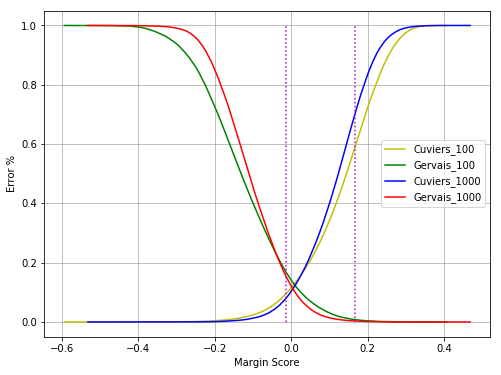

In [29]:
thr_lower_index = np.min(np.where((tpr > 0.92)))
thr_upper_index = np.max(np.where((tpr  < 0.3)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
#print("Thresholds (lower, upper):", thr_lower, thr_upper)
acc,cuvier_acc, gervais_acc, abstain = xgbh.statistics(y_pred_1000, y_test, thr_lower, thr_upper)
print("Accuracy: %f,\nCuvier Accuracy: %f,\nGervais Accuracy: %f,\nAbstain: %f" % (acc, cuvier_acc, gervais_acc, abstain))

thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)

plt.figure(figsize=(8, 6))
legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()